In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import date
from datetime import timedelta
from sklearn.impute import SimpleImputer

In [2]:
def peak_boost(preds, scalar, mixed=None):
    '''A function to boost peaks of the predictions'''
    #Take derivative of predictions
    deriv = np.gradient(preds)
    #Scale derivative
    new_deriv = deriv * scalar
    #Integrate the new derivative starting from 0
    integral = cumtrapz(new_deriv, initial=0)
    length = range(len(preds))
    #Add intercept to match initial range
    boosted = [x+preds[0] for x in integral]
    
    #Option ways to put floors on the output, preventing negative case counts
    if mixed == 'max':
        out = [max(boosted[i], preds[i]) for i in length]
    elif mixed == 'pos':
        out = [max(boosted[i], 0) for i in length]
    else:
        out = boosted
    
    #Doubling values above a 0.992 threshold in order to better estimate peak cases.
    Ser = pd.Series(out)
    
    quantile_value = Ser.quantile(q=0.99)
    print(f'Values are doubled over this threshold: {quantile_value}')
    
    for k,v in Ser.items():
        if (v > quantile_value):
            Ser[k] = int(Ser[k]*2)
    
    return np.array([int(x) for x in Ser])


In [3]:
#Import training data
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)


(1456, 25)


In [4]:
#Splitting data for each city (San Juan, Puerto Rico & Iquitos, Peru)
data_sj = data.iloc[:936,:]
data_iq = data.iloc[936:,:]

In [5]:
data_sj[['precipitation_amt_mm', 'station_avg_temp_c',
           'reanalysis_dew_point_temp_k', 'station_max_temp_c','station_min_temp_c','reanalysis_relative_humidity_percent',]]

,precipitation_amt_mm,station_avg_temp_c,reanalysis_dew_point_temp_k,station_max_temp_c,station_min_temp_c,reanalysis_relative_humidity_percent
0,12.42,25.442857,292.414286,29.4,20.0,73.365714
1,22.82,26.714286,293.951429,31.7,22.2,77.368571
2,34.54,26.714286,295.434286,32.2,22.8,82.052857
3,15.36,27.471429,295.310000,33.3,23.3,80.337143
4,7.52,28.942857,295.821429,35.0,23.9,80.460000
...,...,...,...,...,...,...
931,27.19,25.042857,292.095714,30.0,21.1,74.247143
932,3.82,26.242857,293.235714,30.6,22.2,74.600000
933,16.96,25.000000,292.732857,29.4,21.7,75.027143
934,0.00,25.314286,292.274286,29.4,21.7,72.285714


In [6]:
#Convert kelvin to celcius
def converter(x):
    return x-273.15
data_sj['dew_point_temp_c'] = data_sj['reanalysis_dew_point_temp_k'].map(converter)
data_sj['dew_point_temp_c']  

/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_19185/4280243343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sj['dew_point_temp_c'] = data_sj['reanalysis_dew_point_temp_k'].map(converter)


0      19.264286
1      20.801429
2      22.284286
3      22.160000
4      22.671429
         ...    
931    18.945714
932    20.085714
933    19.582857
934    19.124286
935    21.130000
Name: dew_point_temp_c, Length: 936, dtype: float64

In [7]:
def preprocess_historical(data):
    
    #Reset index to prevent issues when merging
    reindexed_data = data.reset_index(drop = True)
    
    #Fill nas with interpolation
    features = reindexed_data.interpolate(method='linear')
    
    features = features[['precipitation_amt_mm', 'station_avg_temp_c',
           'reanalysis_dew_point_temp_k', 'station_max_temp_c','station_min_temp_c','reanalysis_relative_humidity_percent']]
    
    #Convert kelvin to celcius
    def converter(x):
        return x-273.15
    features['dew_point_temp_c'] = features['reanalysis_dew_point_temp_k'].map(converter)
    
    df = pd.DataFrame()
    df['precip'] = features['precipitation_amt_mm']
    df['temp'] = features['station_avg_temp_c']
    df['max_temp'] = features['station_max_temp_c']
    df['min_temp'] = features['station_min_temp_c']
    df['humidity'] = features['reanalysis_relative_humidity_percent']
    df['dew_point'] = features['dew_point_temp_c']
    
    #Add lagged features for 4 weeks
    to_shift = ['precip','temp',
       'max_temp','min_temp','humidity','dew_point'] 
    for i in to_shift:
        df[i+'_1lag'] = df[i].shift(+1)
        df[i+'_2lag'] = df[i].shift(+2)
        df[i+'_3lag'] = df[i].shift(+3)
        df[i+'_4lag'] = df[i].shift(+4)
    df = df.fillna(method='bfill')
    
    return df


In [8]:
sj_data = preprocess_historical(data_sj)
iq_data = preprocess_historical(data_iq)

In [9]:
sj_data

,precip,temp,max_temp,min_temp,humidity,dew_point,precip_1lag,precip_2lag,precip_3lag,precip_4lag,...,min_temp_3lag,min_temp_4lag,humidity_1lag,humidity_2lag,humidity_3lag,humidity_4lag,dew_point_1lag,dew_point_2lag,dew_point_3lag,dew_point_4lag
0,12.42,25.442857,29.4,20.0,73.365714,19.264286,12.42,12.42,12.42,12.42,...,20.0,20.0,73.365714,73.365714,73.365714,73.365714,19.264286,19.264286,19.264286,19.264286
1,22.82,26.714286,31.7,22.2,77.368571,20.801429,12.42,12.42,12.42,12.42,...,20.0,20.0,73.365714,73.365714,73.365714,73.365714,19.264286,19.264286,19.264286,19.264286
2,34.54,26.714286,32.2,22.8,82.052857,22.284286,22.82,12.42,12.42,12.42,...,20.0,20.0,77.368571,73.365714,73.365714,73.365714,20.801429,19.264286,19.264286,19.264286
3,15.36,27.471429,33.3,23.3,80.337143,22.160000,34.54,22.82,12.42,12.42,...,20.0,20.0,82.052857,77.368571,73.365714,73.365714,22.284286,20.801429,19.264286,19.264286
4,7.52,28.942857,35.0,23.9,80.460000,22.671429,15.36,34.54,22.82,12.42,...,22.2,20.0,80.337143,82.052857,77.368571,73.365714,22.160000,22.284286,20.801429,19.264286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,27.19,25.042857,30.0,21.1,74.247143,18.945714,0.00,0.00,0.00,0.00,...,21.1,21.1,72.915714,71.934286,74.681429,72.660000,19.055714,19.047143,19.902857,19.352857
932,3.82,26.242857,30.6,22.2,74.600000,20.085714,27.19,0.00,0.00,0.00,...,22.2,21.1,74.247143,72.915714,71.934286,74.681429,18.945714,19.055714,19.047143,19.902857
933,16.96,25.000000,29.4,21.7,75.027143,19.582857,3.82,27.19,0.00,0.00,...,20.6,22.2,74.600000,74.247143,72.915714,71.934286,20.085714,18.945714,19.055714,19.047143
934,0.00,25.314286,29.4,21.7,72.285714,19.124286,16.96,3.82,27.19,0.00,...,21.1,20.6,75.027143,74.600000,74.247143,72.915714,19.582857,20.085714,18.945714,19.055714


In [ ]:
today = date.today()
future = today + timedelta(days=14)
start = today  - timedelta(days=180)
future = str(future)
start = str(start)
sj_url = f"https://api.open-meteo.com/v1/forecast?latitude=18.47&longitude=-66.11&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m&models=best_match&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto&start_date={start}&end_date={future}"
iq_url = f"https://api.open-meteo.com/v1/forecast?latitude=-3.75&longitude=-73.25&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m&models=best_match&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto&start_date={start}&end_date={future}"
sj_forecast = preprocess_api(sj_url)
iq_forecast = preprocess_api(iq_url)

In [10]:
data = requests.get(iq_url).json()
    
hourly_data = pd.DataFrame(data['hourly'])
hourly_data['time'] = pd.to_datetime(hourly_data['time'])
hourly_data = hourly_data.groupby(pd.Grouper(key="time", freq="1W")).mean()

daily_data = pd.DataFrame(data['daily'])
daily_data['time'] = pd.to_datetime(daily_data['time'])
daily_data = daily_data.groupby(pd.Grouper(key="time", freq="1W")).mean()

NameError: name 'iq_url' is not defined

In [25]:
def preprocess_api(url):
    
    data = requests.get(url).json()
    
    hourly_data = pd.DataFrame(data['hourly'])
    hourly_data['time'] = pd.to_datetime(hourly_data['time'])
    hourly_data = hourly_data.groupby(pd.Grouper(key="time", freq="1W")).mean()

    daily_data = pd.DataFrame(data['daily'])
    daily_data['time'] = pd.to_datetime(daily_data['time'])
    daily_data = daily_data.groupby(pd.Grouper(key="time", freq="1W")).mean()
    
    combined_data = hourly_data.join(daily_data)

    df = pd.DataFrame()
    df['precip'] = combined_data['precipitation_sum']
    df['temp'] = combined_data['temperature_2m']
    df['max_temp'] = combined_data['temperature_2m_max']
    df['min_temp'] = combined_data['temperature_2m_min']
    df['humidity'] = combined_data['relativehumidity_2m']
    df['dew_point'] = combined_data['dewpoint_2m']
    
    #Reset index
    final_df = df.reset_index(drop = True)
    
    #Add lagged features for 4 weeks
    to_shift = ['precip','temp',
       'max_temp','min_temp','humidity','dew_point'] 
    for i in to_shift:
        final_df[i+'_1lag'] = final_df[i].shift(+1)
        final_df[i+'_2lag'] = final_df[i].shift(+2)
        final_df[i+'_3lag'] = final_df[i].shift(+3)
        final_df[i+'_4lag'] = final_df[i].shift(+4)
    final_df0 = final_df.fillna(method='bfill')
    final_df = final_df0.fillna(method='ffill')
    return final_df

In [26]:
today = date.today()
future = today + timedelta(days=14)
start = today  - timedelta(days=180)
future = str(future)
start = str(start)
sj_url = f"https://api.open-meteo.com/v1/forecast?latitude=18.47&longitude=-66.11&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m&models=best_match&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto&start_date={start}&end_date={future}"
iq_url = f"https://api.open-meteo.com/v1/forecast?latitude=-3.75&longitude=-73.25&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m&models=best_match&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto&start_date={start}&end_date={future}"
sj_forecast = preprocess_api(sj_url)
iq_forecast = preprocess_api(iq_url)

In [27]:
sj_forecast

,precip,temp,max_temp,min_temp,humidity,dew_point,precip_1lag,precip_2lag,precip_3lag,precip_4lag,...,min_temp_3lag,min_temp_4lag,humidity_1lag,humidity_2lag,humidity_3lag,humidity_4lag,dew_point_1lag,dew_point_2lag,dew_point_3lag,dew_point_4lag
0,5.425000,28.148958,30.725000,26.525000,78.885417,24.039583,5.425000,5.425000,5.425000,5.425000,...,26.525000,26.525000,78.885417,78.885417,78.885417,78.885417,24.039583,24.039583,24.039583,24.039583
1,2.200000,28.202976,30.685714,26.285714,77.886905,23.847024,5.425000,5.425000,5.425000,5.425000,...,26.525000,26.525000,78.885417,78.885417,78.885417,78.885417,24.039583,24.039583,24.039583,24.039583
2,2.485714,28.333929,30.557143,26.685714,78.273810,24.095833,2.200000,5.425000,5.425000,5.425000,...,26.525000,26.525000,77.886905,78.885417,78.885417,78.885417,23.847024,24.039583,24.039583,24.039583
3,3.714286,28.351786,31.300000,26.442857,79.892857,24.414881,2.485714,2.200000,5.425000,5.425000,...,26.525000,26.525000,78.273810,77.886905,78.885417,78.885417,24.095833,23.847024,24.039583,24.039583
4,11.028571,28.226786,30.057143,26.914286,79.125000,24.171429,3.714286,2.485714,2.200000,5.425000,...,26.285714,26.525000,79.892857,78.273810,77.886905,78.885417,24.414881,24.095833,23.847024,24.039583
5,0.971429,28.251190,31.142857,26.214286,78.464286,23.967857,11.028571,3.714286,2.485714,2.200000,...,26.685714,26.285714,79.125000,79.892857,78.273810,77.886905,24.171429,24.414881,24.095833,23.847024
6,3.585714,27.905357,31.100000,25.842857,78.410714,23.644643,0.971429,11.028571,3.714286,2.485714,...,26.442857,26.685714,78.464286,79.125000,79.892857,78.273810,23.967857,24.171429,24.414881,24.095833
7,2.300000,28.017857,30.642857,26.328571,78.833333,23.873810,3.585714,0.971429,11.028571,3.714286,...,26.914286,26.442857,78.410714,78.464286,79.125000,79.892857,23.644643,23.967857,24.171429,24.414881
8,1.457143,27.540476,29.871429,25.557143,80.761905,23.823214,2.300000,3.585714,0.971429,11.028571,...,26.214286,26.914286,78.833333,78.410714,78.464286,79.125000,23.873810,23.644643,23.967857,24.171429
9,1.028571,27.842857,30.485714,25.757143,78.392857,23.552976,1.457143,2.300000,3.585714,0.971429,...,25.842857,26.214286,80.761905,78.833333,78.410714,78.464286,23.823214,23.873810,23.644643,23.967857


In [177]:
iq_X = iq_data
iq_y = data_iq.total_cases
iq_y.shape,iq_X.shape

((520,), (520, 30))

In [178]:
sj_X = sj_data
sj_y = data_sj.total_cases
sj_y.shape,sj_X.shape

((936,), (936, 30))

In [179]:
#Results from Grid Search
rf_params = {'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 3,
 'n_estimators': 90,
 'warm_start': False}

In [180]:
#Initialize models
sj_rf_model = RandomForestRegressor(**rf_params, criterion='absolute_error')
iq_rf_model = RandomForestRegressor(**rf_params, criterion='absolute_error')

#Fitting models on training data
sj_rf_model.fit(sj_X, sj_y)
iq_rf_model.fit(iq_X, iq_y)

print('Training Complete!')

#Making predictions on training and testing data for San Juan
sj_pred = sj_rf_model.predict(sj_forecast).astype(int)
iq_pred = iq_rf_model.predict(iq_forecast).astype(int)

Training Complete!


In [181]:
sj_pred,iq_pred

(array([32, 33, 31, 29, 25, 22, 26, 32, 32, 36, 35, 34, 32, 26, 27, 23, 26,
        21, 26, 31, 29, 34, 34, 32, 26, 21, 38, 37]),
 array([ 4,  4,  3,  3,  4,  4,  4,  6,  5,  5,  5,  4,  3,  4,  4,  6,  5,
         7,  8, 10, 10,  8, 10,  9,  8,  7, 10,  6]))

In [197]:
sj_boost = peak_boost(sj_pred, 4, 'max')
iq_boost = peak_boost(iq_pred, 2.5, 'max')

Values are doubled over this threshold: 49.84
Values are doubled over this threshold: 17.75


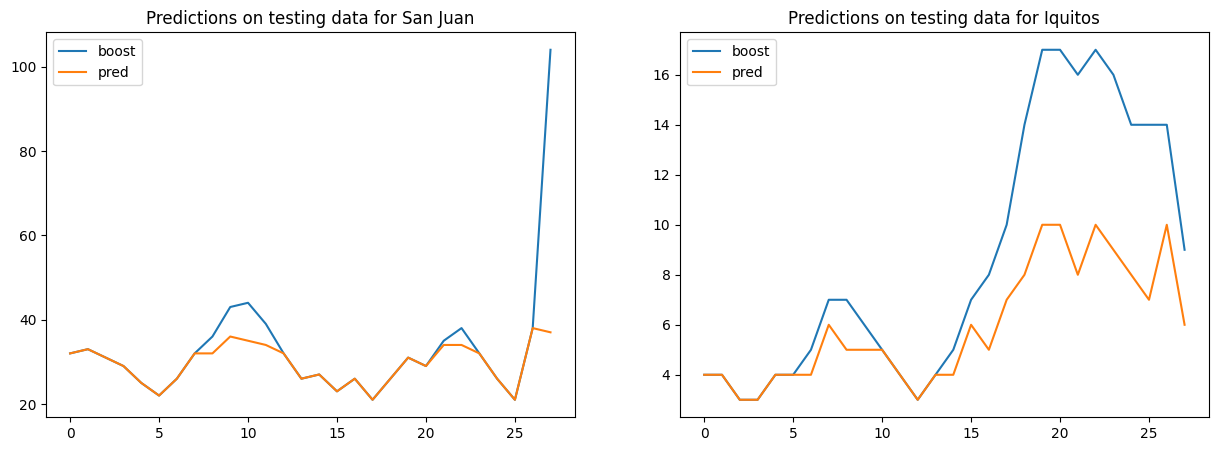

In [198]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_boost, label='boost')
plt.plot(sj_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for San Juan')
plt.show;
plt.subplot(122)
plt.plot(iq_boost, label='boost')
plt.plot(iq_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for Iquitos')
plt.show;

In [186]:
sj_pred[-2:]

array([38, 37])

In [187]:
iq_pred[-2:]

array([10,  6])